# Email Spam Detection — Numbered Notebook (with **6.9 BERT**)
This notebook follows a numbered structure and adds a **BERT** detector while leaving classic ML sections intact.

## 0. Setup (Dependencies & Imports)

In [2]:
# 0.1 Install runtime dependencies (Colab-friendly)
!pip -q install -U tensorflow_text tensorflow_hub --quiet
!pip -q install "transformers==4.44.2" --quiet   # <-- add this line

# 0.2 Standard imports
import os, re, math, random, collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools  # <-- add this (you use itertools.product later)

import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
from tqdm.notebook import tqdm

# 0.3 ML/metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix,
                             f1_score, precision_score, recall_score, accuracy_score,
                             roc_curve, auc, precision_recall_curve)  # <-- you use these later

# 0.4 TensorFlow / TF-Hub for BERT
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

# 0.5 Transformers (add this)
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification  # <-- add this

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 51.1 MB/s eta 0:00:00


In [3]:
# Mount Drive to import dataset
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


## 1. Data Exploration

In [4]:
# 1.1 Configure data path (adjust as needed)
# Expected columns: 'subject', 'body', 'label' (0=ham, 1=spam). If your CSV has different columns, adapt below.
DATA_PATH = '/content/drive/My Drive/AI dataset/CEAS_08.csv'  # <-- change if needed

# 1.2 Load raw data
df = pd.read_csv(DATA_PATH)

# 1.3 Basic info
# Keep ONLY the required columns for modeling
required_cols = ['body', 'label']
missing = [c for c in required_cols if c not in df.columns]
if missing:
    print("WARNING: Missing required columns:", missing)

df = (
    df[[c for c in required_cols if c in df.columns]]
    .dropna(subset=[c for c in required_cols if c in df.columns])
    .reset_index(drop=True)
)

target  = 'label'
labels  = ['Spam','Ham']
features = [i for i in df.columns.values if i not in [target]]

original_df = df.copy(deep=True)
display(df.head())

,body,label
0,"Buck up, your troubles caused by small dimensi...",1
1,\nUpgrade your sex and pleasures with these te...,1
2,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1
3,Would anyone object to removing .so from this ...,0
4,\nWelcomeFastShippingCustomerSupport\nhttp://7...,1


## 2. EDA (lightweight)

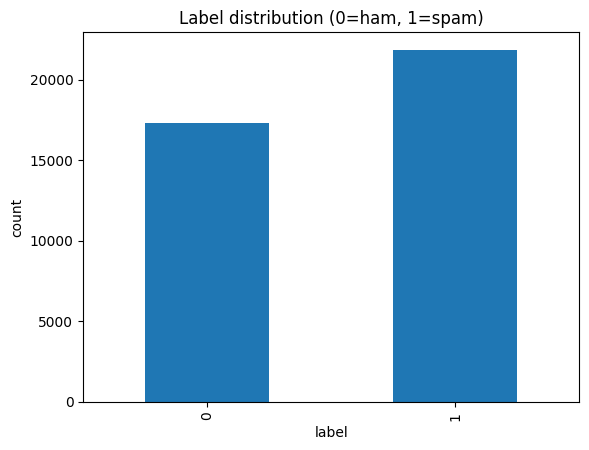

In [5]:
# 2.1 Target distribution (spam vs ham)
label_counts = df['label'].value_counts().sort_index()
plt.figure()
label_counts.plot(kind='bar')
plt.title('Label distribution (0=ham, 1=spam)')
plt.xlabel('label')
plt.ylabel('count')
plt.show()

## 3. Data Preprocessing (text column & label)

In [6]:
# Set of English stopwords
ENGLISH_STOP_WORDS = set(stopwords.words('english'))

# Enhanced text cleaning function
def clean_text(text):
    text = str(text).lower()  # Lowercase
    text = re.sub(r"http\S+|www\S+", "", text)  # Remove URLs
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    tokens = word_tokenize(text)  # Tokenize
    tokens = [word for word in tokens if word not in ENGLISH_STOP_WORDS]  # Remove stopwords
    text = ' '.join(tokens)  # Rejoin for vectorizers
    text = re.sub(r"\s+", " ", text).strip()  # Remove extra spaces
    return text

# Apply cleaning with progress bar
tqdm.pandas(desc="Cleaning text")
df['clean_body'] = df['body'].progress_apply(clean_text)

# Quick look at the results
df[['body', 'clean_body']].head()

Cleaning text:   0%|          | 0/39154 [00:00<?, ?it/s]

,body,clean_body
0,"Buck up, your troubles caused by small dimensi...",buck troubles caused small dimension soon beco...
1,\nUpgrade your sex and pleasures with these te...,upgrade sex pleasures techniques
2,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,daily top 10 cnncom top videos stories aug 1 2...
3,Would anyone object to removing .so from this ...,would anyone object removing list tld basicall...
4,\nWelcomeFastShippingCustomerSupport\nhttp://7...,welcomefastshippingcustomersupport


## 4. Data Manipulation (splits for BERT; classic pipeline unchanged)

In [18]:
# 4.1 Prepare raw-text splits for BERT (80/10/10)
X_text = df['body'].values
y_lbl  = df['label'].values

X_train_text, X_tmp_text, y_train_lbl, y_tmp_lbl = train_test_split(
    X_text, y_lbl, test_size=0.2, random_state=SEED, stratify=y_lbl
)
X_val_text, X_test_text, y_val_lbl, y_test_lbl = train_test_split(
    X_tmp_text, y_tmp_lbl, test_size=0.5, random_state=SEED, stratify=y_tmp_lbl
)

print(f"BERT splits — train: {len(X_train_text)}, val: {len(X_val_text)}, test: {len(X_test_text)}")

# 4.2 Init the comparison table (classic models + BERT)
Evaluation_Results = pd.DataFrame(columns=['Model','Accuracy(%)','Precision(%)','Recall(%)','F1-score(%)'])
display(Evaluation_Results)

BERT splits — train: 31323, val: 3915, test: 3916


,Model,Accuracy(%),Precision(%),Recall(%),F1-score(%)


## 5. Feature Selection / Extraction (kept for classic ML; BERT uses raw text)

In [19]:
pass

## 6. Predictive Modeling

### 6.1–6.8 Classic models (optional / unchanged)

In [20]:
# Place your classic models (LR, DT, RF, NB, SVM, KNN, GB, XGB) here if you wish.
# After computing metrics for each, append to Evaluation_Results like:
# Evaluation_Results.loc[len(Evaluation_Results)] = ['ModelName', acc*100, prec*100, rec*100, f1*100]
pass

### 6.9 BERT (TF-Hub small_bert)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/286 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/45.1M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1: loss=0.0681  train_acc=0.9791  val_acc=0.9936
Epoch 2: loss=0.0149  train_acc=0.9959  val_acc=0.9929
Epoch 3: loss=0.0066  train_acc=0.9980  val_acc=0.9977
Epoch 4: loss=0.0036  train_acc=0.9987  val_acc=0.9972
Epoch 5: loss=0.0038  train_acc=0.9987  val_acc=0.9972
Epoch 6: loss=0.0018  train_acc=0.9994  val_acc=0.9964
Epoch 7: loss=0.0028  train_acc=0.9992  val_acc=0.9969
Epoch 8: loss=0.0012  train_acc=0.9996  val_acc=0.9974
Epoch 9: loss=0.0011  train_acc=0.9996  val_acc=0.9972
Epoch 10: loss=0.0008  train_acc=0.9998  val_acc=0.9969
Epoch 11: loss=0.0006  train_acc=0.9998  val_acc=0.9957
Epoch 12: loss=0.0015  train_acc=0.9995  val_acc=0.9974
Epoch 13: loss=0.0005  train_acc=0.9998  val_acc=0.9969
Epoch 14: loss=0.0000  train_acc=1.0000  val_acc=0.9969
Epoch 15: loss=0.0013  train_acc=0.9997  val_acc=0.9974
245/245 [==============================] - 8s 27ms/step

BERT (Transformers, TF manual loop) — Test Metrics
Accuracy:  0.9980
Precision: 0.9986
Recall:    0.9977
F1-scor

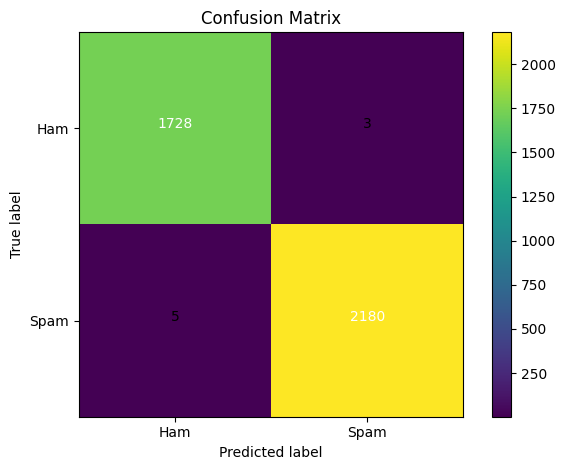

('/content/bert_spam_classifier_transformers/tokenizer_config.json',
 '/content/bert_spam_classifier_transformers/special_tokens_map.json',
 '/content/bert_spam_classifier_transformers/vocab.txt',
 '/content/bert_spam_classifier_transformers/added_tokens.json',
 '/content/bert_spam_classifier_transformers/tokenizer.json')

In [21]:
# 6.9.1 Tokenizer & TF model loaded from PyTorch weights (no model.compile)
MODEL_NAME = "prajjwal1/bert-mini" # Changed to a lighter BERT model

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

bert_model = TFAutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2,
    from_pt=True   # <-- important: convert PT safetensors -> TF weights
)

# Optimizer and loss (we won't call model.compile())
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss_fn   = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# 6.9.2 Tokenize and build tf.data datasets
def tokenize_texts(texts, tokenizer, max_len=256):
    enc = tokenizer(
        list(texts),
        padding=True,
        truncation=True,
        max_length=max_len,
        return_tensors="tf"
    )
    return enc

enc_train = tokenize_texts(X_train_text, tokenizer)
enc_val   = tokenize_texts(X_val_text, tokenizer)
enc_test  = tokenize_texts(X_test_text, tokenizer)

batch_size = 16
train_ds = tf.data.Dataset.from_tensor_slices((dict(enc_train), y_train_lbl)).shuffle(2048, seed=SEED).batch(batch_size)
val_ds   = tf.data.Dataset.from_tensor_slices((dict(enc_val),   y_val_lbl)).batch(batch_size)
test_ds  = tf.data.Dataset.from_tensor_slices((dict(enc_test),  y_test_lbl)).batch(batch_size)

# Class weights for imbalance (same as before)
import collections
cc = collections.Counter(y_train_lbl.tolist())
neg, pos = cc.get(0,1), cc.get(1,1)
tot = neg + pos
class_weights = tf.constant([tot/(2.0*neg), tot/(2.0*pos)], dtype=tf.float32)

@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        out = bert_model(
            input_ids=x["input_ids"],
            attention_mask=x["attention_mask"],
            token_type_ids=x.get("token_type_ids"),
            training=True
        )
        logits = out.logits  # [B,2]
        weights = tf.gather(class_weights, y)
        loss = loss_fn(y, logits, sample_weight=weights)
    grads = tape.gradient(loss, bert_model.trainable_variables)
    optimizer.apply_gradients(zip(grads, bert_model.trainable_variables))
    preds = tf.argmax(logits, axis=-1, output_type=tf.int32)
    acc = tf.reduce_mean(tf.cast(tf.equal(preds, tf.cast(y, tf.int32)), tf.float32))
    return loss, acc

@tf.function
def val_step(batch_inputs, batch_labels):
    outputs = bert_model(
        input_ids=batch_inputs["input_ids"],
        attention_mask=batch_inputs["attention_mask"],
        token_type_ids=batch_inputs.get("token_type_ids"),
        training=False,
    )
    logits = outputs.logits
    preds = tf.argmax(logits, axis=-1, output_type=tf.int32)
    acc = tf.reduce_mean(tf.cast(tf.equal(preds, tf.cast(batch_labels, tf.int32)), tf.float32))
    return acc

# 6.9.3 Evaluate: confusion matrix, report, ROC, PR, and append to Evaluation_Results

EPOCHS = 15  # Reverted epochs for the lighter model
for e in range(1, EPOCHS+1):
    trL, trA = [], []
    for xb, yb in train_ds:
        L, A = train_step(xb, yb)
        trL.append(L.numpy()); trA.append(A.numpy())
    va = [val_step(xb, yb).numpy() for xb, yb in val_ds]
    print(f"Epoch {e}: loss={np.mean(trL):.4f}  train_acc={np.mean(trA):.4f}  val_acc={np.mean(va):.4f}")

# 6.9.3 Evaluate — confusion matrix, report, ROC, PR, table
pred = bert_model.predict(test_ds)
probs = tf.nn.softmax(pred.logits, axis=-1).numpy()
y_pred = probs.argmax(axis=1)
p_spam = probs[:, 1]

acc = accuracy_score(y_test_lbl, y_pred)
prec = precision_score(y_test_lbl, y_pred, zero_division=0)
rec  = recall_score(y_test_lbl, y_pred, zero_division=0)
f1   = f1_score(y_test_lbl, y_pred, zero_division=0)

print("\n\033[1mBERT (Transformers, TF manual loop) — Test Metrics\033[0m")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-score:  {f1:.4f}\n")

print("Classification report:")
print(classification_report(y_test_lbl, y_pred, digits=4))

cm = confusion_matrix(y_test_lbl, y_pred)
print("Confusion matrix [[TN, FP], [FN, TP]]:\n", cm)

# Plot confusion matrix heatmap using matplotlib (no seaborn)
plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Ham', 'Spam'])
plt.yticks(tick_marks, ['Ham', 'Spam'])

thresh = cm.max() / 2.0
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()


# Example:
# preds, probs = bert_predict_text(["Free entry to win cash now!!!", "Hi, let's meet at 3pm."])
# list(zip(preds, probs))

# ============
# 6.10 Save/Load
# ============
SAVE_DIR = '/content/bert_spam_classifier_transformers'
bert_model.save_pretrained(SAVE_DIR)
tokenizer.save_pretrained(SAVE_DIR)

### 6.10 Save / Load

In [22]:
# 6.10 Save
SAVE_DIR = '/content/bert_spam_classifier_tfhub'
bert_model.save(SAVE_DIR)

# 6.10.1 Load example
# reloaded = tf.keras.models.load_model(SAVE_DIR, custom_objects={'KerasLayer': hub.KerasLayer})
# reloaded.predict(["this is a test"])